In [18]:
def set_hadoop_config(credentials):
    prefix = "fs.swift.service." + credentials['name'] 
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + ".auth.url", credentials['auth_url']+'/v3/auth/tokens')
    hconf.set(prefix + ".auth.endpoint.prefix", "endpoints")
    hconf.set(prefix + ".tenant", credentials['project_id'])
    hconf.set(prefix + ".username", credentials['user_id'])
    hconf.set(prefix + ".password", credentials['password'])
    hconf.setInt(prefix + ".http.port", 8080)
    hconf.set(prefix + ".region", credentials['region'])
    hconf.setBoolean(prefix + ".public", True)

In [20]:
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_45aca203_b622_4dbe_aea0_219df4639d0e',
  'project_id':'504cd86539bb403bb2d4871d457f0f09',
  'region':'dallas',
  'user_id':'75ad2d2624f2448aa5b58a83d07dec35',
  'domain_id':'7ecd023a3aac4bc8a7cc71e317eed361',
  'domain_name':'1141105',
  'username':'admin_4797485d56d7b0262bfaae7e2b46f0128a1b1cd7',
  'password':"""JH4^/h3l445Cd()t""",
  'filename':'Restaurant_Inspection_Scores3.csv',
  'container':'notebooks',
  'tenantId':'sf30-ffe13fdb4171b9-19ffada6507b'
}

In [21]:
credentials['name'] = 'keystone'
set_hadoop_config(credentials)

In [22]:
from __future__ import division
import numpy as np

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# adding the PySpark modul to SparkContext
sc.addPyFile("https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py")
import pyspark_csv as pycsv

inspection = sc.textFile("swift://" + credentials['container'] + "." + credentials['name'] + "/Restaurant_Inspection_Scores3.csv")

def skip_header(idx, iterator):
    if (idx == 0):
        next(iterator)
    return iterator

inspection_header = inspection.first()


inspection_header_list = inspection_header.split(",")
inspection_body = inspection.mapPartitionsWithIndex(skip_header)

# filter not valid rows
inspection_body = inspection_body.filter(lambda line : len(line.split(","))>7)

# create Spark DataFrame using pyspark-csv
inspection_df = pycsv.csvToDataFrame(sqlContext, inspection_body, sep=",", columns=inspection_header_list)
inspection_df.cache()


DataFrame[Restaurant Name: string, Zip Code: int, Inspection Date: timestamp, Score: int, latitude: double, longitude: double, Facility ID: int, Process Description: string]

In [23]:
inspection_df.printSchema()

root
 |-- Restaurant Name: string (nullable = true)
 |-- Zip Code: integer (nullable = true)
 |-- Inspection Date: timestamp (nullable = true)
 |-- Score: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- Facility ID: integer (nullable = true)
 |-- Process Description: string (nullable = true)



In [24]:
inspection_df.count()

22778

In [25]:
inspection_df.take(1)

[Row(Restaurant Name=u'Twin Creeks CC Temp Snack Bar', Zip Code=78613, Inspection Date=datetime.datetime(2015, 1, 27, 0, 0), Score=100, latitude=30.461368, longitude=-97.856685, Facility ID=2802235, Process Description=u'Routine Inspection')]

In [26]:
!pip install --user seaborn

In [27]:

%matplotlib inline

import matplotlib.pyplot as plt
# matplotlib.patches allows us create colored patches, we can use for legends in plots
import matplotlib.patches as mpatches
# seaborn also builds on matplotlib and adds graphical features and new plot types
import seaborn as sns
import pandas as pd

inspection_pd = inspection_df[inspection_df['latitude'] != 0][['latitude', 'longitude', 'Score', 'Inspection Date']].toPandas()

inspection_pd.columns = ['latitude', 'longitude', 'Score', 'Inspection Date']

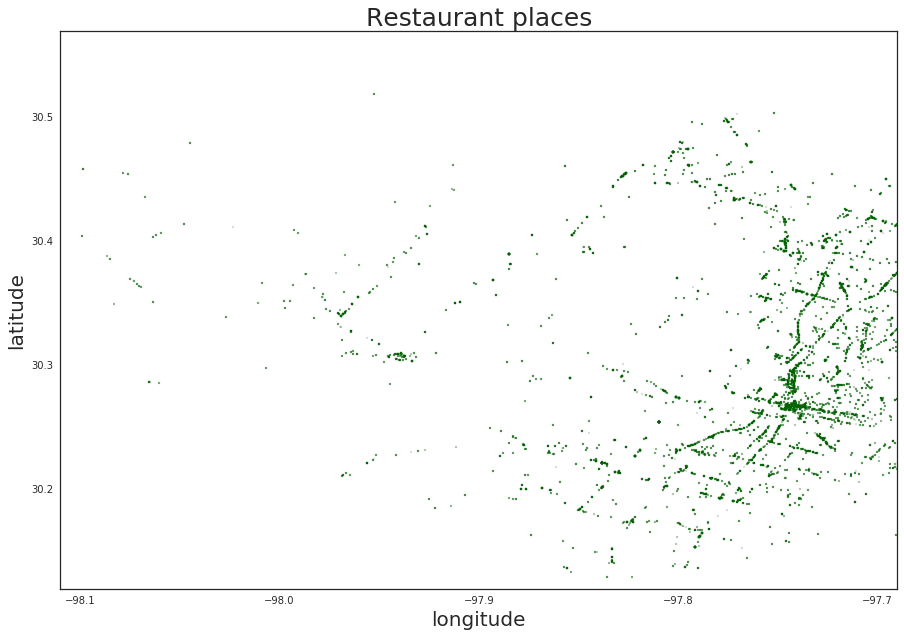

In [28]:
#adjust settings
sns.set_style("white")
plt.figure(figsize=(15,10))

#create scatterplots
plt.scatter(inspection_pd.longitude, inspection_pd.latitude, alpha=0.15, s=4, color='darkgreen')

#adjust more settings
plt.title('Restaurant places', size=25)
plt.xlim((-98.11,-97.69))
plt.ylim((30.12,30.57))
plt.xlabel('longitude',size=20)
plt.ylabel('latitude',size=20)

plt.show()

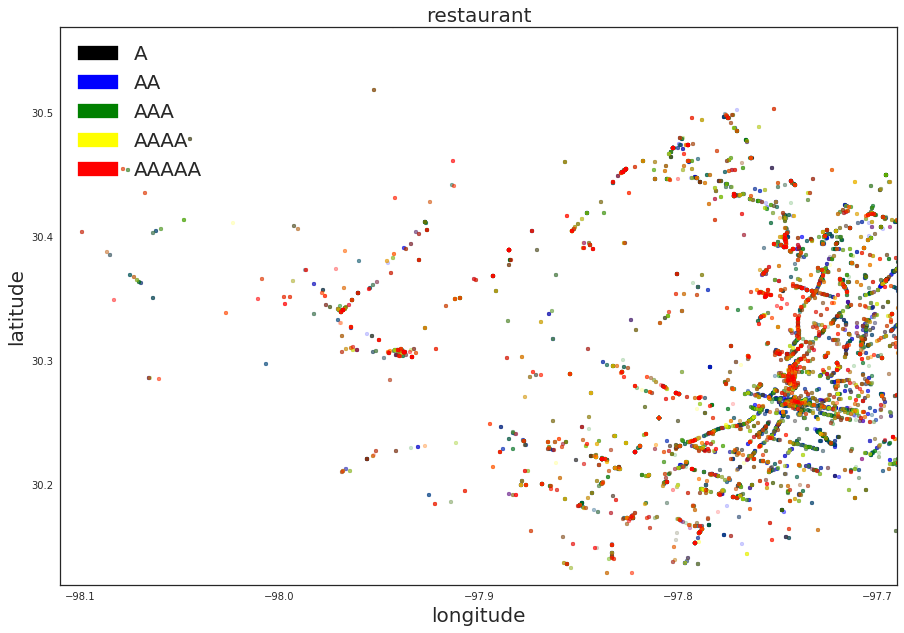

In [29]:
A= inspection_pd[np.logical_and(inspection_pd['Score']>50,inspection_pd['Score']<81)]
AA= inspection_pd[np.logical_and(inspection_pd['Score']>80,inspection_pd['Score']<91)]
AAA= inspection_pd[np.logical_and(inspection_pd['Score']>90,inspection_pd['Score']<97)]
AAAA= inspection_pd[np.logical_and(inspection_pd['Score']>96,inspection_pd['Score']<100)]
AAAAA= inspection_pd[np.logical_and(inspection_pd['Score']>99,inspection_pd['Score']<101)]

plt.figure(figsize=(15,10), dpi=0.1)

#create scatterplots
plt.scatter(A.longitude,A.latitude, s=60,alpha=0.2, color='black', marker ='.')
plt.scatter(AA.longitude,AA.latitude, s=60, alpha=0.2, color='blue', marker ='.')
plt.scatter(AAA.longitude,AAA.latitude, s=60,alpha=0.2,  color='green', marker ='.')
plt.scatter(AAAA.longitude,AAAA.latitude, s=60,alpha=0.2, color='yellow', marker ='.')
plt.scatter(AAAAA.longitude,AAAAA.latitude, s=60,alpha=0.2,  color='red', marker ='.')


#create legend
black_patch = mpatches.Patch(label='A',color ='black')
blue_patch = mpatches.Patch(label='AA',color ='blue')
green_patch = mpatches.Patch(label='AAA',color ='green')
yellow_patch = mpatches.Patch(label='AAAA',color ='yellow')
red_patch = mpatches.Patch(label='AAAAA',color ='red')
plt.legend([black_patch, blue_patch, green_patch, yellow_patch, red_patch],
           ('A', 'AA', 'AAA', 'AAAA', 'AAAAA'), 
           loc='upper left', prop={'size':20})

#adjust more settings
plt.title('restaurant', size=20)
plt.xlim((-98.11,-97.69))
plt.ylim((30.12,30.57))
plt.xlabel('longitude',size=20)
plt.ylabel('latitude',size=20)
plt.show()